

<img src="https://drive.google.com/uc?export=view&id=1wpQMFbiopOgqZ8MMseUDCorEhxWVu9FM" width="450" height="400" align='right' />


## Amirkabir Artificial Intelligence Summer Summit

### Generative Adversarial Networks Workshop



#### Mohammad Rahmdel

www.github.com/Mohammad-Rahmdel


##### Amirkabir Artificial Intelligence Summer Summit
##### Computer Engineering Department of Amirkabir University of Technology




In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import time
%matplotlib inline

In [2]:
tf.random.set_seed(4)

## MNIST
including training set of 60,000 examples and a test set of 10,000 examples with shape=(28, 28, 1) <br>

<img src="https://drive.google.com/uc?export=view&id=1ftlHhbrklwMhjQCJ4CnkAljuehqMEeEH" width="600" height="300" />

## Fashion MNIST
Fashion-MNIST is a dataset of Zalando's article images consisting of a training set of **60,000 examples** and a test set of 10,000 examples. Each example is a **28x28 grayscale image**, associated with a label from 10 classes. <br>

<img src="https://drive.google.com/uc?export=view&id=1ow_1m3myyn0zUomr6U9KFGQfSaNa9u33" width="800" height="400" />

## Cifar10
The CIFAR-10 dataset consists of **60000 32x32 colour images(shape=(32, 32, 3)) in 10 classes**, with 6000 images per class. There are 50000 training images and 10000 test images. <br>

<img src="https://drive.google.com/uc?export=view&id=1Nn02QbIXnznQKGrVp_GLlL9QX4f3DtH9" width="600" height="300" />

## CelebA 
CelebFaces Attributes Dataset (CelebA) is a large-scale face attributes dataset with more than 200K celebrity images, each with 40 attribute annotations. The images in this dataset cover large pose variations and background clutter. CelebA has large diversities, large quantities, and rich annotations, including - 10,177 number ofidentities, - 202,599 number of face images, and - 5 landmark locations, 40 binary attributes annotations per image. <br>
shape of each image = **218x178** <br>

<img src="https://drive.google.com/uc?export=view&id=1XDgeIu833WPhsiGd1ndHKtbTU0jURVka" width="600" height="300" />


In [3]:
dataset = 'fashion_mnist' # ['cifar10', 'fashion_mnist', 'mnist', 'celebA]
batch_size = 64
epochs = 25 ## enough for all datasets
lr = 0.0002
beta_1 = 0.5
n_z = 128
adversarial_loss_mode = 'lsgan' # ['gan', 'lsgan']
n_d_updates = 1

## Mean Squared Error

<img src="https://drive.google.com/uc?export=view&id=1isUz0oOaDZzwALO0B4A_TWLFwoK1MJ4T" width="400" height="100" />


In [4]:
DIM = (28, 28, 1) if dataset != 'cifar10' else  (32, 32, 3)
n_G_upsamplings = n_D_downsamplings = 3  ### 3 for 32x32 and 4 for 64x64=celeba

In [5]:
def Load_celebA():
    from pydrive.auth import GoogleAuth
    from pydrive.drive import GoogleDrive
    from google.colab import auth
    from oauth2client.client import GoogleCredentials

    print('authentication')
    auth.authenticate_user()
    gauth = GoogleAuth()
    gauth.credentials = GoogleCredentials.get_application_default()
    drive = GoogleDrive(gauth)

    print('loading data ...')
    downloaded = drive.CreateFile({'id':"1-4idKN6_JkR-IKcQYp_8hxEm1DwJUje1"})
    downloaded.GetContentFile('celebA.npz') 
    print('celebA loaded')

In [6]:
def normalize(train_images):
    train_images = train_images.reshape(train_images.shape[0],DIM[0],DIM[1],DIM[2]).astype('float32') / 255.0 ## [0-1]
    train_images = train_images * 2 - 1 ## [0,1] to [-1,1]
    return train_images

In [7]:
n_G_upsamplings = n_D_downsamplings = 3  ### 3 for 32x32 and 4 for 64x64=celeba

if dataset == 'cifar10':
    (train_images, _), (test_images, _) = tf.keras.datasets.cifar10.load_data()
    train_images = normalize(train_images)

elif dataset == 'fashion_mnist':
    (train_images, _), (test_images, _) = tf.keras.datasets.fashion_mnist.load_data()
    train_images = normalize(train_images)

elif dataset == 'mnist':
    (train_images, _), (test_images, _) = tf.keras.datasets.mnist.load_data()
    
elif dataset == 'celebA':
    n_G_upsamplings = n_D_downsamplings = 4
    DIM = (64, 64, 3)
    Load_celebA()
    train_images = np.load('/content/celebA.npz')
    train_images = train_images['arr_0'][:20000]
    train_images = train_images.astype('float32') / 255.0 ## [0-1]
    train_images = train_images * 2 - 1 ## [0,1] to [-1,1]

In [8]:
train_images.shape

(60000, 28, 28, 1)

In [9]:
if dataset == 'fashion_mnist' or dataset == 'mnist':
    train_images = tf.image.resize(train_images, [32, 32])
    DIM = (32, 32, 1)

if dataset == 'celebA':
    train_images = tf.image.resize(train_images, [64, 64])

In [10]:
train_images.shape

TensorShape([60000, 32, 32, 1])

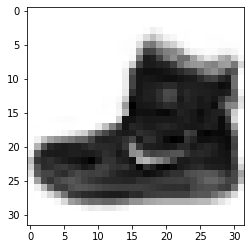

In [11]:
if dataset == 'fashion_mnist' or dataset == 'mnist':
    plt.imshow(train_images.numpy()[0,:,:,0], cmap=plt.cm.Greys)
else:
    plt.imshow(train_images[0] * 0.5 + 0.5)

In [12]:
train_dataset = (
    tf.data.Dataset.from_tensor_slices(train_images)
    .shuffle(train_images.shape[0])
    .batch(batch_size)
)

In [13]:
G_optimizer = tf.keras.optimizers.Adam(lr, beta_1)
D_optimizer = tf.keras.optimizers.Adam(lr, beta_1)

## DCGAN Architecture

<img src="https://drive.google.com/uc?export=view&id=1_l-ld6sIPND43o6NhWsTx2UdHejJpIZp" width="900" height="300" />


<img src="https://drive.google.com/uc?export=view&id=1G-4pzGDB4UbYZTKscKueitUOZF3RkeQv" width="600" height="300" />



In [14]:
def get_disc_layers():
    f = 64  ## number of filters
    kernel_size = 4

    d_layers = [tf.keras.Input(shape=DIM),
                tf.keras.layers.Conv2D(f, kernel_size, strides=2, padding='same'),
                tf.keras.layers.LeakyReLU(0.2)]

    for i in range(n_D_downsamplings - 1):
        f_d = min(f * 2 ** (i + 1), f * 8)
        l1 = tf.keras.layers.Conv2D(f_d, kernel_size, strides=2, padding='same', use_bias=False)
        l2 = tf.keras.layers.BatchNormalization()  ## training=True
        l3 = tf.keras.layers.LeakyReLU(0.2)
        d_layers.extend((l1,l2,l3))
        
    d_layers.append(tf.keras.layers.Conv2D(1, kernel_size, strides=1, padding='valid'))
    
    return d_layers

D = tf.keras.Sequential(get_disc_layers())
D.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 16, 16, 64)        1088      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 128)         131072    
_________________________________________________________________
batch_normalization (BatchNo (None, 8, 8, 128)         512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 256)         524288    
_________________________________________________________________
batch_normalization_1 (Batch (None, 4, 4, 256)         1

In [15]:
def get_gen_layers():
    kernel_size = 4
    f = 64
    f_g = min(f * 2 ** (n_G_upsamplings - 1), f * 8)
    
    g_layers = [ 
        tf.keras.Input(shape=(1,1,n_z)),
        tf.keras.layers.Conv2DTranspose(f_g, kernel_size, strides=2, padding='valid', use_bias=False),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.ReLU()
    ]
    
    for i in range(n_G_upsamplings - 1):
        f_g = min(f * 2 ** (n_G_upsamplings - 2 - i), f * 8)
        l1 = tf.keras.layers.Conv2DTranspose(f_g, kernel_size, strides=2, padding='same', use_bias=False)
        l2 = tf.keras.layers.BatchNormalization()
        l3 = tf.keras.layers.ReLU()
        g_layers.extend((l1,l2,l3))
        

    last = tf.keras.layers.Conv2DTranspose(DIM[-1], kernel_size, strides=2, padding='same', activation='tanh')
    g_layers.append(last)
    
    return g_layers

G = tf.keras.Sequential(get_gen_layers())
G.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_transpose (Conv2DTran (None, 4, 4, 256)         524288    
_________________________________________________________________
batch_normalization_2 (Batch (None, 4, 4, 256)         1024      
_________________________________________________________________
re_lu (ReLU)                 (None, 4, 4, 256)         0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 8, 8, 128)         524288    
_________________________________________________________________
batch_normalization_3 (Batch (None, 8, 8, 128)         512       
_________________________________________________________________
re_lu_1 (ReLU)               (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 16, 16, 64)       

In [16]:
def get_loss(adversarial_loss):
    if adversarial_loss=='gan':
        return tf.keras.losses.BinaryCrossentropy(from_logits=True)
    elif adversarial_loss=='lsgan':
        return tf.keras.losses.mean_squared_error

loss = get_loss(adversarial_loss_mode)

In [17]:
@tf.function
def train_D(x_real):
    with tf.GradientTape() as tape:
        z = tf.random.normal(shape=(x_real.shape[0], 1, 1, n_z))
        x_fake = G(z, training=True)

        D_x_real = D(x_real, training=True)
        D_x_fake = D(x_fake, training=True)

        d1 = loss(tf.ones_like(D_x_real), D_x_real)
        d2 = loss(tf.zeros_like(D_x_fake), D_x_fake)
        D_loss = d1 + d2

    D_gradients = tape.gradient(D_loss, D.trainable_variables)
    D_optimizer.apply_gradients(zip(D_gradients, D.trainable_variables))

    return tf.reduce_mean(d1), tf.reduce_mean(d2)

In [18]:
@tf.function
def train_G(x_real):
    with tf.GradientTape() as tape:
        z = tf.random.normal(shape=(x_real.shape[0], 1, 1, n_z))
        x_gen = G(z, training=True)
        D_x_gen = D(x_gen, training=True)
        G_loss = loss(tf.ones_like(D_x_gen), D_x_gen)

    G_gradients = tape.gradient(G_loss, G.trainable_variables)
    G_optimizer.apply_gradients(zip(G_gradients, G.trainable_variables))

    return tf.reduce_mean(G_loss)

In [19]:
def generate_and_plot(rows=8, cols=8, background='white', seed=None): ## background = 'white' or 'black'

    if seed!=None:
        tf.random.set_seed(seed)
        
    z_samp = tf.random.normal([rows * cols, 1, 1, n_z])
    x_gen = G(z_samp, training=False)

    if rows==8 and cols==8:
        fig, axs = plt.subplots(ncols=cols, nrows=rows, figsize=(cols, rows))
    else:
        fig, axs = plt.subplots(ncols=cols, nrows=rows, figsize=(2 * cols, 2 * rows))
        
    if background=='white':
        fig.patch.set_facecolor('white')
    elif background=='black':
        x_gen *= -1
        fig.patch.set_facecolor('black')

    index = 0
    for row in axs:
        for col in row:
            if dataset == 'fashion_mnist' or dataset == 'mnist':
                col.imshow(x_gen[index,:,:,0], cmap=plt.cm.Greys)
            else:
                col.imshow(x_gen[index] * 0.5 + 0.5)
            col.axis('off')
            index += 1

In [20]:
GLosses = []
DLosses_f = []
DLosses_r = []

In [21]:
def train(n_epochs=1, print_=False):
    t1 = time.time()

    generate_and_plot(2, 8)

    for epoch in range(n_epochs):
        Gloss = []
        Dloss_fake = []
        Dloss_real = []
        for batch in train_dataset:

            D_loss1 = 0 
            D_loss2 = 0
            for _ in range(n_d_updates):
                D_1, D_2 = train_D(batch)
                D_loss1 += D_1
                D_loss2 += D_2
            D_loss1 /= n_d_updates
            D_loss2 /= n_d_updates
            
            G_loss = train_G(batch)

            Gloss.append(G_loss) 
            Dloss_fake.append(D_loss2)
            Dloss_real.append(D_loss1)
        
        DLosses_f.append(np.mean(Dloss_fake))
        DLosses_r.append(np.mean(Dloss_real))
        GLosses.append(np.mean(Gloss))

        if print_:
            print(
            "Epoch: {} | disc_loss_real: {} | disc_loss_fake: {} | gen_loss: {}".format(
                epoch, GLosses[-1], DLosses_f[-1], DLosses_r[-1]
            ))

            # generate_and_plot(2, 8)
    
    t2 = time.time()
    print('total train time: ', t2 - t1)

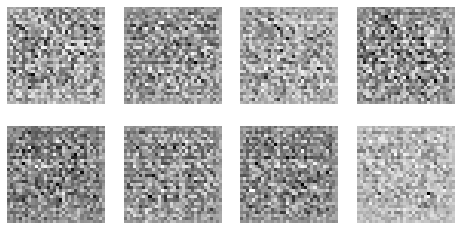

In [22]:
generate_and_plot(2, 4)

Epoch: 0 | disc_loss_real: 1.3773196935653687 | disc_loss_fake: 0.24916304647922516 | gen_loss: 0.13178978860378265
Epoch: 1 | disc_loss_real: 0.7783382534980774 | disc_loss_fake: 0.11080747097730637 | gen_loss: 0.11411864310503006
Epoch: 2 | disc_loss_real: 0.7227040529251099 | disc_loss_fake: 0.13715860247612 | gen_loss: 0.1429573893547058
Epoch: 3 | disc_loss_real: 0.7388947606086731 | disc_loss_fake: 0.1426974982023239 | gen_loss: 0.14990274608135223
Epoch: 4 | disc_loss_real: 0.7688040137290955 | disc_loss_fake: 0.13519388437271118 | gen_loss: 0.14660146832466125
Epoch: 5 | disc_loss_real: 0.8844585418701172 | disc_loss_fake: 0.0863661915063858 | gen_loss: 0.09534160047769547
Epoch: 6 | disc_loss_real: 0.8972649574279785 | disc_loss_fake: 0.08426865190267563 | gen_loss: 0.09259282052516937
Epoch: 7 | disc_loss_real: 0.9082506895065308 | disc_loss_fake: 0.07347612082958221 | gen_loss: 0.08019591122865677
Epoch: 8 | disc_loss_real: 0.9448143243789673 | disc_loss_fake: 0.058437038213

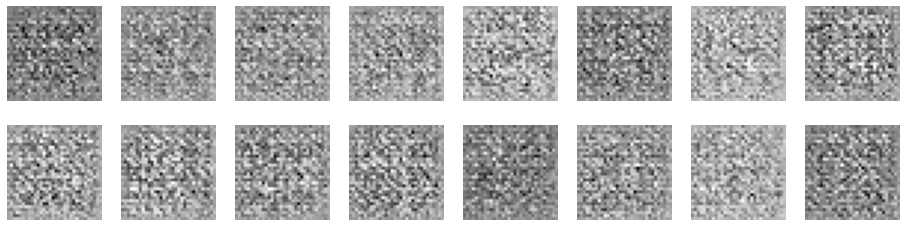

In [23]:
t1 = time.time()
train(25, True)
t2 = time.time()
print('Token Time:', (t2-t1))

In [24]:
def plot_loss():
    plt.plot(DLosses_r, label="D_real")
    plt.plot(DLosses_f, label="D_fake")
    plt.plot(GLosses, label="Gen")
    plt.legend(loc=5)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

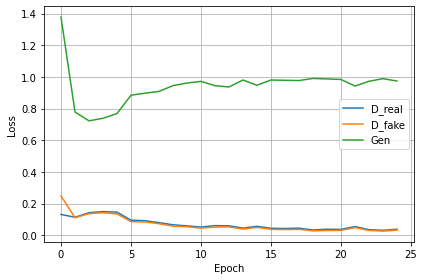

In [25]:
plot_loss()

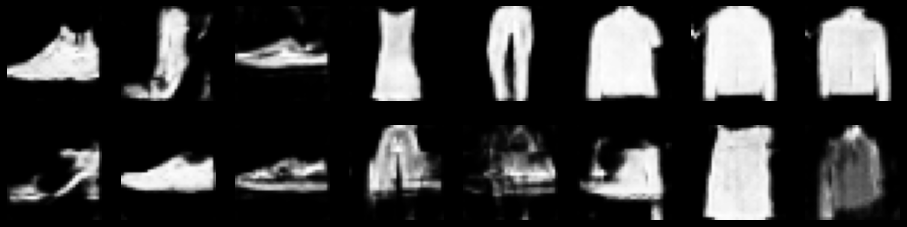

In [26]:
generate_and_plot(2, 8, 'black')

#### No Mode Collapse

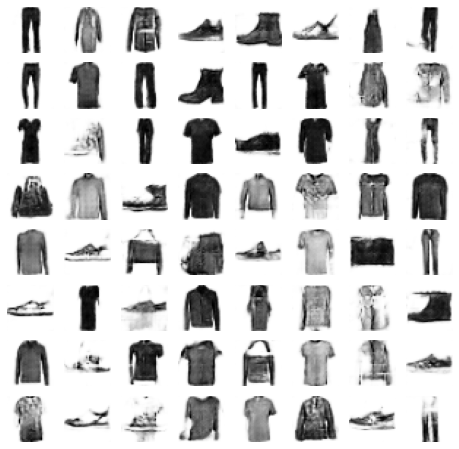

In [27]:
generate_and_plot()

## Embedding Space


<img src="https://drive.google.com/uc?export=view&id=1l8YJSumToYyJebkhYhuyezEeFHg1VSbT" width="900" height="450" />


## Interpolation between Images

In [28]:
def interpolation(seed):

    tf.random.set_seed(seed);
    z_samp = tf.random.normal([2, 1, 1, n_z])

    ratios = np.linspace(0, 1, num=16)

    z_samp[0].shape
    vectors = list()
    for ratio in ratios:
        v = (1.0 - ratio) * z_samp[0] + ratio * z_samp[1]
        vectors.append(v)

    z_ = np.asarray(vectors)
    x_gen = G(z_, training=False)

    fig, axs = plt.subplots(ncols=8, nrows=2, figsize=(12, 4))
    fig.patch.set_facecolor('white')

    index = 0
    for row in axs:
        for col in row:
            if dataset == 'fashion_mnist' or dataset == 'mnist':
                col.imshow(x_gen[index,:,:,0], cmap=plt.cm.Greys)
            else:
                col.imshow(x_gen[index] * 0.5 + 0.5)
            col.axis('off')
            index += 1
    plt.show()

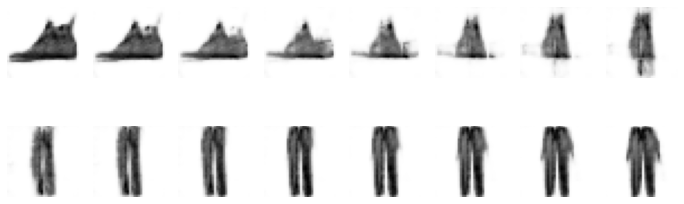

In [32]:
interpolation(14) 

## CelebA Dataset

In [33]:
dataset = 'celebA'
n_G_upsamplings = 4
DIM = (64, 64, 3)

In [34]:
G = tf.keras.Sequential(get_gen_layers())

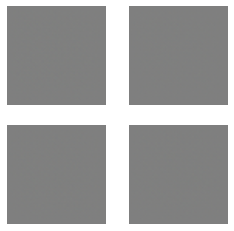

In [35]:
generate_and_plot(2, 2)

Trained for 25 epochs with 20k 64*64 cropped celebA images.

Upload celeb-weights.h5 in colab or train the networks yourself!

In [36]:
G.load_weights('/content/dcgan-celeba-weights.h5')

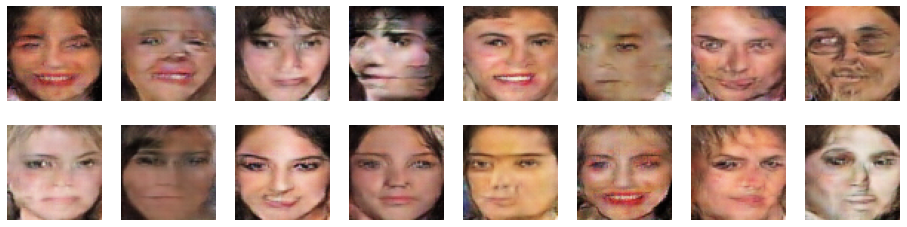

In [37]:
generate_and_plot(2, 8, seed=6)

#### Interpolation


<img src="https://drive.google.com/uc?export=view&id=160zJaXSR6VW23KOQTt8RKsNPAGbiC16u" width="600" height="400" />

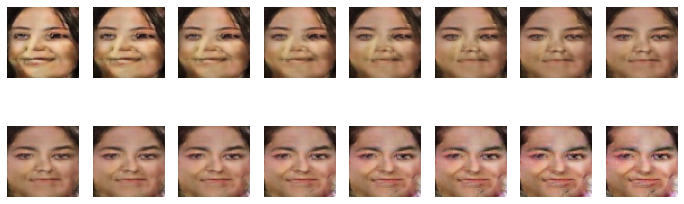

In [38]:
interpolation(21)

## Vector Arithmetic in Latent Space

In [39]:
def generateImage(seed, index):
    tf.random.set_seed(seed)
    z_samp = tf.random.normal([index + 1, 1, 1, n_z])
    sample = z_samp[index]
    sample = G(tf.reshape(sample, shape=(1,1,1,n_z)), training=False)
    return sample

In [40]:
def plot(images):
    plt.figure(figsize=(2*len(images),2))
    for i in range(len(images)):
        plt.subplot(1, len(images), i+1)
        plt.axis('off')
        plt.imshow(tf.reshape(images[i], shape=(64, 64, 3)) * 0.5 + 0.5)
    plt.show()

In [41]:
def merge(z):
    merged = None
    for x in z:
        seed = x[0]
        index = x[1]
        tf.random.set_seed(seed)
        z_samp = tf.random.normal([index + 1, 1, 1, n_z])
        sample = z_samp[index]
        
        merged = sample if merged == None else merged + sample
    
    merged /= len(z)
    return merged 

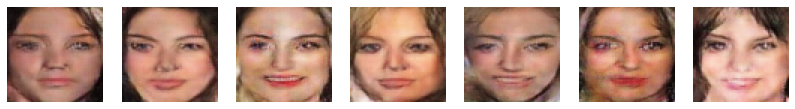

In [42]:
women = []
women.append(generateImage(6,11))
women.append(generateImage(9,14))
women.append(generateImage(11,10))
women.append(generateImage(12,2))
women.append(generateImage(23,11))
women.append(generateImage(30,14))
women.append(generateImage(33,24))
plot(women)

In [43]:
z_ws = merge([[3,5],[8,1],[32,2],[34,11],[34,13]]) ## smiling women
z_w = merge([[6,11],[9,14],[11,10],[12,2],[23,11],[30,14],[32,24]]) ## neutral women
z_m = merge([[7,9],[9,9],[25,1],[30,10]])  ## neutral men

In [44]:
g1 = G(tf.reshape(z_ws, shape=(1,1,1,n_z)), training=False)
g2 = G(tf.reshape(z_w, shape=(1,1,1,n_z)), training=False)
g3 = G(tf.reshape(z_m, shape=(1,1,1,n_z)), training=False)

In [45]:
z_ms = z_ws - z_w + z_m

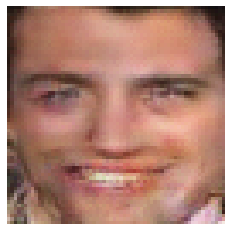

In [46]:
result = G(tf.reshape(z_ms, shape=(1,1,1,n_z)), training=False)
plt.imshow(result[0] * 0.5 + 0.5)
plt.axis('off')
plt.show()

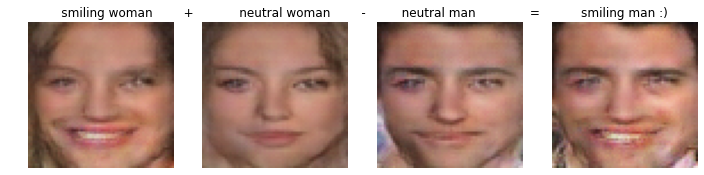

In [47]:
plt.figure(figsize=(3*4,3))

plt.subplot(1, 4, 1)
plt.axis('off')
plt.imshow(tf.reshape(g1[0], shape=(64, 64, 3)) * 0.5 + 0.5)
plt.title(' ' * 14 + 'smiling woman' + ' ' * 8 + '+')

plt.subplot(1, 4, 2)
plt.axis('off')
plt.imshow(tf.reshape(g2[0], shape=(64, 64, 3)) * 0.5 + 0.5)
plt.title(' ' * 14 + 'neutral woman' + ' ' * 8 + '-')

plt.subplot(1, 4, 3)
plt.axis('off')
plt.imshow(tf.reshape(g3[0], shape=(64, 64, 3)) * 0.5 + 0.5)
plt.title(' ' * 11 + 'neutral man' + ' ' * 14 + '=')

plt.subplot(1, 4, 4)
plt.axis('off')
plt.imshow(tf.reshape(result[0], shape=(64, 64, 3)) * 0.5 + 0.5)
plt.title('smiling man :)')

plt.show()